# Практическая работа по распознаванию речи #4: <br> Поиск наилучшей гипотезы распознавания
Задача распознавания речи состоит в поиске наиболее вероятной словной гипотезы по имеющемуся звуковому сигналу. Используя теорему Байеса, формулировку задачи можно написать так:
$$ W^* = \underset{W}{argmax} {P(W|O)} =  \underset{W}{argmax} \sum_i^N{(\log{P(O|w_i)} + \log{P(w_i|w_{i-1}, w_{i-2},..))}}$$
Где: 
* $O$ - звук
* $W$ - словная гипотеза распознавания 
* $W^*$ - лучшая гипотеза распознавания
* $P(W|O)$ - вероятность гипотезы распознавания при условии наблюдения $O$
* $N$ - количество слов в гипотезе
* $w_i$ - i'ое слово в гипотезе
* $P(O|w_i)$ - акустическое правдоподобие слова (выводится из предсказания акустической моделью)
* $P(w_i|w_{i-1}, w_{i-2},..)$ - языковая вероятность слова при условии контекста (предсказывается языковой моделью)


В прошлых лабораторных работах были изучены акустическая и языковая модели. Акустическая модель предсказывает вероятность принадлежности кадра некоему акустическому классу (фонеме). Языковая модель предсказывает априорную вероятность последовательности слов. Пришло время разобраться, как соединить эти части в одну систему и получить итоговый результат распознавания. 





### Основная часть (14 баллов) данной практической работы состоит из двух частей: 
* знакомство с Weighted Finite State Transducer (WFST)
* WFST декодинг в ASR системе

### Дополнительная часть 
* тюнинг параметров beam search (2 балла)

## Полезные ссылки: 
* Наиболее популярная библиотека WFST - [OpenFst](https://www.openfst.org/twiki/bin/view/FST/WebHome)
* Библиотека для визуализации - [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html)
* Алгоритм обхода графа в ширину - [BFS](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%85%D0%BE%D0%B4_%D0%B2_%D1%88%D0%B8%D1%80%D0%B8%D0%BD%D1%83)

In [1]:
!python3 --version 

Python 3.8.20


In [2]:
#!pip install graphviz kenlm kaldiio jiwer

In [72]:
import numpy as np
import time
import os
import abc
import math

from typing import List, Dict, Union, Set, Any, Optional, Tuple
from tqdm.auto import tqdm
from collections import defaultdict
from pathlib import Path
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import graphviz
import kenlm 
import jiwer
from kaldiio import ReadHelper

/home/chernogor/conda/envs/nast/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Weighted Finite State Transducer (WFST)



Из определения в wiki [Weighted Finite State Transducer (Взвешенный конечный автомат с выходом)](https://en.wikipedia.org/wiki/Finite-state_transducer) следует, что главная задача FST - это переводить символы из входного алфавита в соответствующие им символы из выходного алфавита. Например, с помощью FST можно перевести последовательность фонем в последовательность слов. Конечный автомат будет менять свое состояние при обработке последовательности входных символов (фонем). Когда он соберет из входных фонем корректную транскрипцию слова, то выдаст это слово на выход. 

Однако не всегда можно однозначно перевести последовательность фонем в слова (некоторые слова произносятся одинаково, а пишутся по-разному), поэтому для распознавания речи надо использовать не простой FST, а взвешенный. WFST позволяет не только перевести входные символы в выходные, но и оценить вес такого перевода. Чем больше вес, тем хуже гипотеза.  

Напишем собственную реализацию WFST.


### AbstractWFST
AbstractWFST -- это базовый интерфейс нашего WFST. В нем заданы основные методы, через которые мы будем работать с wfst  
* get_start - возвращаяет стартовое состояние конечного автомата.
* final_score - вес завершения работы в данном состоянии. В некоторых состояниях завершить обработку невозможно, в таких случаях final weight  будет равен бесконечности.
*  transduce - совершает переход из текущего состояния в следующее, соответствующее переходу по символу ilabel. Возвращает выходной символ, вес перехода и следующее состояние.  




 

In [73]:
class AbstractWFST(abc.ABC):
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def get_start(self) -> Any:
        """Return start state"""
    
    @abc.abstractmethod
    def final_score(self, state: Any) -> float:
        """is the state final? If true return negative log likelihood of the finalization. otherwise return inf"""
           
    @abc.abstractmethod
    def transduce(self, state: Any, ilabel: str) -> Tuple[Tuple[str, float, Any]]:
        """Transduce ilabel to olabel. 
        return all available olabels for this state and ilabel pair
        return type - ((olabel1, weight1, nextstate1), 
                       ((olabel1, weight1, nextstate1), 
                       ...)"""

### SymbolsMap

Для того, чтобы задать WFST, первым делом нам понадобятся таблицы входных и выходных символов. Для задания таблиц будем использовать класс SymbolsMap. Данный класс служит для маппинга символов на индексы и обратно. 

In [74]:
class SymbolsMap:
    def __init__(self, id2symbol: Optional[Dict[int, str]] = None, symbol2id: Optional[Dict[str, int]] = None):
        assert id2symbol is not None or symbol2id is not None, f"One id2symbol or symbol2id must be not None"
        assert id2symbol is None or symbol2id is None, f"Only one One id2symbol or symbol2id can be not None"
        if id2symbol is None:
            self.id2symbol = {i:s for s,i in symbol2id.items()}
        elif isinstance(id2symbol, dict):
            self.id2symbol = id2symbol
        elif isinstance(id2symbol, list):
            self.id2symbol = {i:s for i, s in enumerate(id2symbol)}
        else:
            raise RuntimeError(f"unknown type {type(id2symbol)=}")
            
        if symbol2id is None:
            self.symbol2id = {s:i for i, s in self.id2symbol.items()}
        else:
            self.symbol2id = symbol2id   
                
        assert self.id2symbol[0] == '<eps>', f"wrong {self.id2symbol}"

    def get_id(self, symbol: str):
        return self.symbol2id[symbol]
        
    def get_symbol(self, id: int):
        return self.id2symbol[id] 
    
    @classmethod
    def from_file(cls, fname):
        """read symbols table from file
        format: 
            word id
            word2 id2
            ...
        """
        with open(fname) as f:
            s2i = {s:int(i) for s, i in map(str.split, f.readlines())}
        return cls(symbol2id=s2i)

### Arc и ILabelIndexedArcs
Переходы внутри FST будем описывать с помощью класса, инкапсулирующего информацию о входном/выходном индексе символа, весе перехода и следующем состоянии FST. Поскольку дуги мы будем хранить отдельно для каждого состояния, информация о текущем состоянии в дуге не нужна. 

Для быстрого выбора нужной дуги создадим специальную коллекцию ILabelIndexedArcs. Данная коллекция хранит дуги таким образом, чтобы выбор дуги по входному символу осуществлялся за O(1). 


In [75]:
@dataclass
class Arc:
    """Arc in WFST"""
    ilabel: int
    olabel: int
    weight: float
    nextstate: Any

class ILabelIndexedArcs:
    def __init__(self, arcs: Optional[List[Arc]] = None):
        self.ilabel2arclist = defaultdict(list)
        if arcs is not None:
            for arc in arcs:
                self.add_arc(arc)

    def add_arc(self, arc: Arc):
        self.ilabel2arclist[arc.ilabel].append(arc)

    def get_arcs_by_ilabel(self, ilabel: int):
        return self.ilabel2arclist[ilabel]

    def arcs(self) -> List[Arc]:
        """Return all arcs"""
        all_arcs = []
        # TODO
        # реализуйте функцию, которая возвращает все дуги, хранящиеся в данной коллекции
        all_arcs = list(self.ilabel2arclist.values())
        all_arcs = [v[0] for v in all_arcs]
        return all_arcs 

    def __str__(self):
        return "ILabelIndexedArcs([" + ", ".join(f"{a}" for a in self.arcs()) + "])"
        
    def __repr__(self):
        return str(self)

In [76]:
# test 1.a
def test_ILabelIndexedArcs():
    # проверка что arcs работает правильно 
    arcs = [Arc(i, -i, i/100, i+100) for i in range(10)]
    c = ILabelIndexedArcs(arcs)
    arcs2 = c.arcs()
    print(arcs2)
    
    assert len(arcs) == len(arcs2), f"{len(arcs)=}, {len(arcs2)=}\n{arcs} != {c.arcs()}"
    for a in arcs2:
        assert a in arcs, f"{a=} not in {arcs=}"
    print('Test 1.a passed')
test_ILabelIndexedArcs()    

[Arc(ilabel=0, olabel=0, weight=0.0, nextstate=100), Arc(ilabel=1, olabel=-1, weight=0.01, nextstate=101), Arc(ilabel=2, olabel=-2, weight=0.02, nextstate=102), Arc(ilabel=3, olabel=-3, weight=0.03, nextstate=103), Arc(ilabel=4, olabel=-4, weight=0.04, nextstate=104), Arc(ilabel=5, olabel=-5, weight=0.05, nextstate=105), Arc(ilabel=6, olabel=-6, weight=0.06, nextstate=106), Arc(ilabel=7, olabel=-7, weight=0.07, nextstate=107), Arc(ilabel=8, olabel=-8, weight=0.08, nextstate=108), Arc(ilabel=9, olabel=-9, weight=0.09, nextstate=109)]
Test 1.a passed


### WFST 
Все готово для создания взвешенного конечного автомата. Класс WFST состоит из таблицы входных и выходных символов, списка состояний и коллекции дуг для каждого, а также множества финальных состояний. 

In [77]:
class WFST(AbstractWFST):
    def __init__(self, 
                 isymbols: Optional[SymbolsMap] = None, 
                 osymbols: Optional[SymbolsMap] = None):
        self.start = 0
        self.states = [0]
        # состояния, в которых может завершиться декодирование без какого либо штрафа 
        self.final_states = set() 
        self.isymbols = isymbols
        self.osymbols = osymbols
        self.state2arcs = defaultdict(ILabelIndexedArcs)

    def get_start(self):
        """return start state"""
        return self.start
        
    def final_score(self, state_id: int):
        """return the weight of decoding completion in state_id"""
        # TODO 
        # верните вес завершения декодирования в state_id
        if state_id not in self.final_states: 
            return float('inf')
        else:
            return 0
         
    def transduce(self, state, ilabel: str) -> Tuple[Tuple[str, float, int]]:
        """transitions wfst to next state by 'ilabel' input symbol, except when the input symbol is <eps>.
        Returns all possible output results as a tuple of triples (olabel, weight, nextstate)."""
        assert self.isymbols is not None and self.osymbols is not None, f"Cannot transduce w/o both symbols tables" 
        if ilabel == '<eps>':
            # skip <eps> input
            return ((ilabel, 0, state), )
        label_id = self.isymbols.get_id(ilabel)
        # TODO 
        # верните все возможные результаты перехода из текущего состояния по входу ilabel
        # результат должен выглядеть так: tuple(("слово", 0.1, 2), ("другоеслово", 10, 4), ...)
        states = []
        for s in self.state2arcs[state].get_arcs_by_ilabel(label_id):
            states.append((self.osymbols.get_symbol(s.olabel), s.weight, s.nextstate))
        return tuple(states)    
        
    def set_final(self, state: int):
        """sets the final weight for the state to zero"""
        # TODO добавьте возможность завершать декодирование в state
        self.final_states.add(state)
        
    def new_state(self):
        """Create new state id and return it"""
        # TODO 
        # добавьте в конечный автомат новое состояние и верните его id 
        state_id = len(self.states)
        self.states.append(state_id)
        return state_id
    
    def add_arc(self, state_from: int, arc: Arc):
        """adds a new arc for this state"""
        # TODO 
        # добавьте в конечный автомат новых переход arc, выходящий из state_from 
        #print(self.state2arcs[state_from])
        self.state2arcs[state_from].add_arc(arc)
    
    def to_dot(self):
        """Visualize the WFST""" 
        dot = graphviz.Digraph()
        for s in self.states:
            dot.node(str(s))
        for state_from, arcs_container in self.state2arcs.items():
            for arc in arcs_container.arcs():
                il = self.isymbols.get_symbol(arc.ilabel) if self.isymbols is not None else arc.ilabel
                ol = self.osymbols.get_symbol(arc.olabel) if self.osymbols is not None else arc.olabel
                dot.edge(str(state_from), str(arc.nextstate), label=f"{il}:{ol}:{arc.weight:.2f}")
        return dot
    

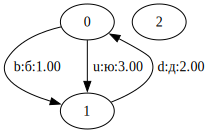

(('б', 1.0, 1),)
test 1.b passed


In [78]:
# test 1.b
def test_WFST():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'б', 'д'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    # new_state
    en2ru_final = en2ru.new_state()
    assert en2ru_final == 1 , f'start - zero, next state - one, next - two ...'
    assert en2ru.new_state() == 2, f'start - zero, next state - one, next - two ...'
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 2, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 3, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    display.display(en2ru.to_dot())

    # final_score # set_final
    assert en2ru.final_score(en2ru.get_start()) == float('inf')
    assert en2ru.final_score(en2ru_final) == 0
    en2ru.set_final(en2ru.get_start())
    assert en2ru.final_score(en2ru_final) == en2ru.final_score(en2ru.get_start()) == 0

    print(en2ru.transduce(en2ru.get_start(), 'b'))
    # transduce # add_arc
    assert en2ru.transduce(en2ru.get_start(), 'd') == tuple() , "Cannot transduce 'd' from start state. output must be zero len tuple"
    assert en2ru.transduce(en2ru.get_start(), 'b') == (('б', 1.0, en2ru_final), ) , "Arc(1, 2, 1.0, en2ru_final)"
    assert en2ru.transduce(en2ru.get_start(), 'u') == (('ю', 3.0, en2ru_final), ) , "Arc(3, 1, 3.0, en2ru_final)"
    assert en2ru.transduce(en2ru_final, 'd') == (('д', 2.0, en2ru.get_start()), ) , "Arc(2, 3, 2.0, en2ru.get_start())"
    
    print('test 1.b passed')
test_WFST()

## wfst композиция 


Над WFST определен большой набор различных операций, реализация большинства из которых является сложной алгоритмической задачей. Важной для распознавания речи операцией является [композиция](https://www.openfst.org/twiki/bin/view/FST/ComposeDoc) набора различных wfst. 

OpenFST дает следующее определение композиции:
 
"This operation computes the composition of two transducers. If A transduces string x to y with weight a and B transduces y to z with weight b, then their composition transduces string x to z with weight a ⊗ b."

Другими словами, результатом композиции является wfst, применение которого к входной последовательности даст такой же результат, как и последовательное применение композируемых wfst. 

Хорошим примером композиции различных WFST является граф распознавания в гибридных системах распознавания речи. Такой граф является результатом композиции четырех wfst:
* H - Hidden Markov Model wfst (переводит акустические классы, предсказанные с помощью AM, в трифоны)
* С - Context-dependency transducer (переводит трифоны (тройки (leftcontext,phone,rightcontext)) в фонемы)
* L - lexicon (переводит фонемы в слова)
* G - ngram lm (оценивает вероятность последовательностей слов)
 
Итого граф распознавания можно выразить с помощью следующей формулы:
$$ HCLG = H⊗C⊗L⊗G $$ 
где ⊗ - оператор композиции двух wfst. Подробнее про граф распознавания можно почитать в [документации к фреймворку kaldi](https://kaldi-asr.org/doc/graph.html)


Композиция позволяет объединить много обработчиков в один большой граф, что несомненно является большим плюсом для построения продакшн решений. Но у такого подхода есть и минусы - процесс подготовки графа очень сложен и требует множества оптимизаций. Это усложняет любые эксперименты и модификации системы. В данной работе мы не будем реализовывать честную композицию графа, а будем считать композицию "On the Fly". То есть сделаем обертку, реализующую интерфейс AbstractWFST, состоянием которой будет Tuple состояний всех композируемых wfst, а метод transduce будет последовательно проходить через эти wfst. Тем самым, по определению композиции, наш класс будет эквивалентен честной композиции.  



In [79]:
class OnTheFlyCompose(AbstractWFST):
    def __init__(self, wfsts: List[AbstractWFST]):
        # !!!Attention!!! wfsts - это лист AbstractWFST, а не WFST. 
        # Для работы с wfsts истользуйте только методы из AbstractWFST
        self.wfsts = wfsts

    def get_start(self):
        return tuple(fst.get_start() for fst in self.wfsts)

    def final_score(self, state: Tuple[Any]):
        assert len(state) == len(self.wfsts)
        # TODO 
        # посчитайте финальный скор для state
        # результат композиции может завершить обработку только в тех стейтах, где все wfsts будут в финальных состояниях
        score = 0
        for i, s in enumerate(state):
                score += self.wfsts[i].final_score(s)
        return score    
    
    def _transduce(self, state: Tuple[Any], ilabel: str) -> List[Tuple[List[str], float, List[int]]]:
        assert len(self.wfsts) == len(state)
        # Найдите все возможные гипотезы перевода ilabel с помощью композиции всех self.wfsts
        # Последовательно пройдите через все self.wfsts, расширяя список гипотез и дополняя гипотезы новыми слоями 
        # Верните результат в виде списка гипотез. 
        # Каждая гипотеза содержит три элемента: 
        #   0. список символов со ВСЕХ прошедших слоев композиции 
        #   1. суммарный вес гипотезы 
        #   2. список состояний, в которые перешли self.wfsts 

        # Одна стартовая гипотеза. Корень для всех гипотез.
        # Еще никакой wfst не применен, символ только ilabel, вес стартовый, стейтов еще нет. 
        
        def expand_hyps(hyp, state, fst): 
            # "расширяем" гипотезу переходами по всем дугам из ее последнего состояния 
            final_hyps = []
            labels, w, states = hyp
            tr_out = fst.transduce(state, labels[-1])
            for out in tr_out:
                l, w0, s = out
                final_hyps.append([labels+[l], w+w0, states+[s]])
            return final_hyps
        
        hyps_per_layer = [([ilabel], 0, [])]  
        for fst, s in zip(self.wfsts, state):
            new_hyps = []
            # TODO 
            # примените fst.transduce ко всем гипотезам из hyps_per_layer
            # постепенно разветвляя их и сохраняя в new_hyp
            # на вход подайте выход последнего из уже обработаных слоев 
            for hyp in hyps_per_layer:
                new_hyps += expand_hyps(hyp, s, fst)
            hyps_per_layer = new_hyps
        return hyps_per_layer

    def transduce(self, state: Tuple[Any], ilabel: str):
        hyps_per_layer = self._transduce(state, ilabel)
        # выходной символ transduce в композиции - это выходной символ самого последнего wfst 
        return tuple((ls[-1], w, tuple(ss)) for ls, w, ss in hyps_per_layer)
    

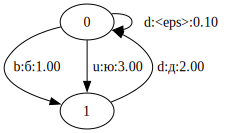

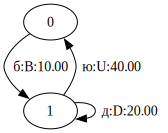

Test 1.c passed


In [80]:
def test_OnTheFlyCompose():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'д', 'б'])
    en_U = SymbolsMap(id2symbol=['<eps>', 'B', 'D', 'U'])
    ru_U = SymbolsMap(id2symbol=['<eps>', 'Ю', 'Д', 'Б'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    en2ru_final = en2ru.new_state()
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 3, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 2, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(2, 0, 0.1, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    display.display(en2ru.to_dot())

    # OnTheFlyCompose одного fst работает так же как и этот fst
    comp = OnTheFlyCompose([en2ru])
    for s in (0, 1):
        for il in 'bdu':
            hyps1 = en2ru.transduce(s, il)
            hyps2 = comp.transduce((s,), il)
            for h in hyps2:
                # only one state
                assert len(h[2]) == 1, f"{hyps2=}"
            hyps2_flatten = tuple((l, w, ss[0]) for l,w,ss in hyps2)
            assert hyps1 == hyps2_flatten, f"{hyps1=} {hyps2_flatten=}"
        
        scores = [float('inf'), 0]
        your_score = comp.final_score((s,))
        assert your_score == scores[s], f"Your score = {your_score}, correct = {scores[s]}"

    # create second transducer
    ru2en = WFST(isymbols=ru_l, osymbols=en_U)
    ru2en_final = ru2en.new_state()
    ru2en.set_final(ru2en_final)
    ru2en.add_arc(ru2en.get_start(), Arc(3, 1, 10.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 20.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 30.0, ru2en.get_start()))
    ru2en.add_arc(ru2en_final, Arc(1, 3, 40.0, ru2en.get_start()))
    
    # you can use this line to visualize
    display.display(ru2en.to_dot())

    # композиция двух работает как последовательное применение каждого 
    comp = OnTheFlyCompose([en2ru, ru2en])
    hyps = comp.transduce((0, 0), 'b')
    assert hyps == (('B', 11.0, (1, 1)), ) , f"{hyps =}"
    hyps = comp.transduce((1, 1), 'd')
    assert hyps == (('D', 22.0, (0, 1)), ('D', 32.0, (0, 0))) , f"{hyps =}"
    hyps = comp.transduce((0, 1), 'd')
    assert hyps == (('<eps>', 0.1, (0, 1)), ) , f"{hyps =}"
    # Проверка правильности расчетов final_score
    your_score = comp.final_score((0, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((0, 1))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 1))
    assert your_score == 0, f"Your score = {your_score}, correct = {0}"
    print('Test 1.c passed')
    
    
test_OnTheFlyCompose()

# 2. WFST декодинг в ASR системе
Отлично, код WFST готов, теперь необходимо собрать граф распознавания и написать поиск наилучшей гипотезы 




In [81]:
# Сначала подготовим нужные нам таблицы символов
AM_PHONES = {0: 'pau', 1: 'aa', 2: 'ae', 3: 'ah', 4: 'ao', 5: 'aw', 6: 'ax', 7: 'ax-h', 8: 'axr', 9: 'ay', 10: 'b', 
             11: 'bcl', 12: 'ch', 13: 'd', 14: 'dcl', 15: 'dh', 16: 'dx', 17: 'eh', 18: 'el', 19: 'em', 20: 'en', 
             21: 'eng', 22: 'er', 23: 'ey', 24: 'f', 25: 'g', 26: 'gcl', 27: 'hh', 28: 'hv', 29: 'ih', 30: 'ix', 
             31: 'iy', 32: 'jh', 33: 'k', 34: 'kcl', 35: 'l', 36: 'm', 37: 'n', 38: 'ng', 39: 'nx', 40: 'ow', 
             41: 'oy', 42: 'p', 43: 'pcl', 44: 'q', 45: 'r', 46: 's', 47: 'sh', 48: 't', 49: 'tcl', 50: 'th', 
             51: 'uh', 52: 'uw', 53: 'ux', 54: 'v', 55: 'w', 56: 'y', 57: 'z', 58: 'zh'}

# таблица фонем для wfst 
def create_phones_txt(fname='exp/phones.txt'):
    fname = Path(fname) 
    fname.parent.mkdir(exist_ok=True, parents=True)
    with open(fname, 'w') as f:
        f.write('<eps> 0\n') # !! shift all ids by one !! 
        for i, p in sorted(AM_PHONES.items()):
            f.write(f'{p} {i+1}\n')
create_phones_txt()


In [82]:
# Загрузим подготовленный лексикон из датасета 
def load_lexicon_file(fname='timit/TIMITDIC.TXT', words_limit=-1):
    """generator running through the 'fname' phonetic dictionary 
    yield (word: str, phones: List[str])"""
    num = 0
    with open(fname) as f:
        for line in map(str.strip, f.readlines()):
            if line.startswith(';'):
                continue
            word, trans, _ = line.split('/')
            # remove ~adj suffix 
            word = word.split('~')[0].strip() 
            # remove stress factor
            trans = [t[:-1] if t[-1].isdigit() else t for t in trans.split()]
            yield word, trans
            num += 1
            if words_limit == num:
                break

In [83]:
# подготовим таблицу слов
def create_words_txt(fname='exp/words.txt', dic_fname='timit/TIMITDIC.TXT'):
    fname = Path(fname)
    fname.parent.mkdir(exist_ok=True, parents=True)
    words = ['<eps>'] + [w for w, _ in sorted(load_lexicon_file(dic_fname))] + ['<s>', '</s>']
    with open(fname, 'w') as f:
        f.write(''.join(f'{w} {i}\n' for i, w in enumerate(words)))
create_words_txt()

# T transducer

Создадим первый wfst. 

В гибридном пайплайне системы распознавания речи задача первых двух wfst (H и C) - это перевести предсказанные с помощью акустической модели классы в последовательность фонем. В нашем случае все значительно легче, так как АМ (из работы №3) уже учится предсказывать фонемы, поэтому мы не будем использовать HС трансдьюсеры. 

В этой работе будет использоваться простой трасдьюсер T. Этот wfst нужен для преобразования вероятностей фонем, которые оценивает AM, в их правдоподобие. Используя теорему Баеса, сделать это преобразование легко. Надо просто добавить к скорам фонем их априорную вероятность.


T.wfst состоит из одного состояния и N петель, где N - это количество фонем. Каждая петля соответствует определенной фонеме и хранит логарифм ее априорной вероятности.

![image](resources/lab4/H_example.svg)

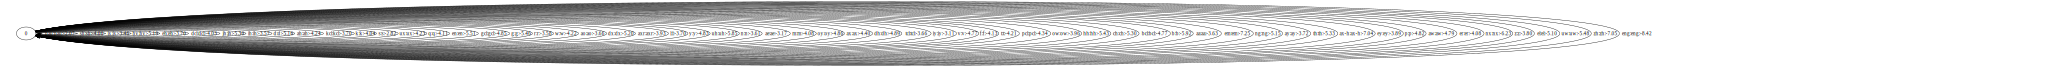

In [84]:
def create_t_wfst(prior_file='resources/lab4/phone.priors', phones_fname='exp/phones.txt'):
    """Create T.wfst. just transduce AM probability to AM likelihood (Bayes theorem)
    """
    symbols = SymbolsMap.from_file(phones_fname)
    t_fst = WFST(isymbols=symbols, osymbols=symbols)
    s = t_fst.get_start()
    t_fst.set_final(s)
    with open(prior_file) as f:
        for ph, prior in map(str.split, f.readlines()):
            log_prior = np.log(float(prior))
            ph_id = symbols.get_id(ph)
            t_fst.add_arc(s, Arc(ph_id, ph_id, log_prior, s))
    return t_fst
create_t_wfst().to_dot()

# L transducer

Lwfst - это WFST, который преобразует входные последовательности фонем в слова.

Например, `pau pau ae1 ae1 ae1 ae1 ae1 ae1 r pau pau pau y y y y eh1 s s s pau` -> `air yes`

Чтобы контролировать количество слов в выходной гипотезе, в L добавляется два веса: 
* word_insertion_penalty - штраф за добавление слова 
* stay_in_silence_penalty - штраф за пропуск паузы (фонемы pau)

Пример Lwfst, построенного для слов `'em` `-knacks`, с параметрами word_insertion_penalty=0.5, stay_in_silence_penalty=0.01

![image](./resources/lab4/L_example.svg)

Фонема паузы pau обрабатывается особым способом: L.fst может пропускать ее, не генерируя ничего на выходе. Также у окончания каждой транскрипции слова есть две отдельные дуги, возвращающие FST в стартовое состояние. Это нужно для того, чтобы была возможность как обработать подряд идущие дупликаты последней фонемы на конце слова, так и перейти в стартовое состояние всего по одной финальной фонеме. 

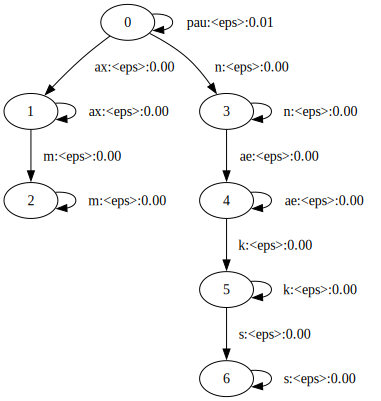

In [85]:
def create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT', 
                           phones_fname='exp/phones.txt', 
                           words_fname='exp/words.txt', 
                           words_limit=-1,
                           word_insertion_penalty=0.5, 
                           stay_in_silence_penalty=0.01):
    isymbols = SymbolsMap.from_file(phones_fname)
    osymbols = SymbolsMap.from_file(words_fname)
    sil_id = isymbols.get_id('pau')
    l_wfst = WFST(isymbols=isymbols, osymbols=osymbols)
    start = l_wfst.get_start()
    ### Пропуск скольких угодно фонем тишины
    l_wfst.add_arc(start, Arc(sil_id, 0, stay_in_silence_penalty, start))
    # Стартовое состояние также является и финальным
    l_wfst.set_final(start)
    
    for word, trans in load_lexicon_file(dic_fname, words_limit=words_limit):
        tran_ids = [isymbols.get_id(t) for t in trans]
        word_id = osymbols.get_id(word)
        # TODO 
        # Добавьте последовательные дуги в wfst, определяющие транскрипцию слова
        # Все дуги, кроме последней, на выходе имеют <eps>
        # Последняя дуга выводит word_id и возвращает конечный автомат в стартовое (оно же финальное) состояние
        # Каждая фонема может тянуться от 1 до inf кадров, поэтому помимо переходов в новое состояние, должны быть еще петли 
        tran_len = len(tran_ids)
        state = start
        for i in range(len(tran_ids)): 
            new_state = l_wfst.new_state()
            l_wfst.add_arc(state, Arc(tran_ids[i], 0, 0, new_state))
            l_wfst.add_arc(new_state, Arc(tran_ids[i], 0, 0, new_state))    
            if i == tran_len-1:
                l_wfst.add_arc(new_state, Arc(tran_ids[i], word_id, word_insertion_penalty, start))
                l_wfst.add_arc(state, Arc(tran_ids[i], word_id, word_insertion_penalty, start))
            state = new_state
    return l_wfst
create_Lwfst_from_file(words_limit=2, word_insertion_penalty=0.5, stay_in_silence_penalty=0.01).to_dot()

In [86]:
def test_l_wfst():
    l_wfst = create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT', 
                                    word_insertion_penalty=1.0, stay_in_silence_penalty=0.01)
    start = l_wfst.get_start()
    hyps = l_wfst.transduce(start, 'pau')
    loop_hyp = [(l, w, s) for l, w, s in hyps if s == start]
    assert (len(loop_hyp) == 1 
            and loop_hyp[0][0] == '<eps>' 
            and loop_hyp[0][1] == 0.01), f"{hyps}\n skip pause test failed"
    # смотрим, что поданная на вход транскрипция корректно переводится в слово
    # количество подряд идущих одинаковых фонем постепенно увеличивается от одной до 6
    for i, (word, trans) in enumerate(tqdm(load_lexicon_file('timit/TIMITDIC.TXT', words_limit=100), total=100)):
        hyps = [('', 0, l_wfst.get_start()), ]
        # Breadth First Search
        for t in [t for t in trans for _ in range(i//20+1)]:
            # t repeated many times
            new_hyps = []
            for prev_l, prev_w, prev_s in hyps: 
                new_hyps.extend([(f"{prev_l} {l}", prev_w + w, s) for l,w,s in l_wfst.transduce(prev_s, t)])
            hyps = new_hyps
        # choose only final hyp
        # ограничение веса нужно, чтобы отсечь гипотезы где комбинация других слов мапится на теже фонемы
        hyps = [(l, w, s) for l, w, s in hyps if l_wfst.final_score(s) != float('inf') and w == 1.0]
       
        assert len(hyps) == 1 or len(trans) == 1 , f"Test failed for word \"{word}\" {hyps=}"
        assert hyps[0][0].replace('<eps>', ' ').split() == [word], f"Test failed for word {word} {hyps=}"
        assert hyps[0][1] == 1.0, f"Test failed for word {word} {hyps=}"
        assert hyps[0][2] == start, f"Test failed for word {word} {hyps=}"       
    print("test 2.a passed")
test_l_wfst()

100%|██████████| 100/100 [00:05<00:00, 18.65it/s]

test 2.a passed


# Поиск наилучшей гипотезы распознавания с помощью beam search

Для того, чтобы найти результат распознавания с помощью акустической модели и графа распознавания, надо выполнить поиск наилучшей гипотезы в графе. Для поиска лучшего пути будем использовать [лучевой поиск (Beam Search)](https://ru.wikipedia.org/wiki/%D0%9B%D1%83%D1%87%D0%B5%D0%B2%D0%BE%D0%B9_%D0%BF%D0%BE%D0%B8%D1%81%D0%BA). В основе этого алгоритма лежит обход графа в ширину, но на каждом шаге рассматриваются только наиболее "хорошие" гипотезы, а остальные уничтожаются. Такая эвристика позволяет значительно ускорить процесс декодирования, но не всегда находит наилучший путь. 

In [87]:
@dataclass(order=True)
class Hypothesis:
    # накопленный штраф гипотезы
    score: float
    # до какого кадра из входной последовательности дошла гипотеза
    time: int
    # накопленная последовательность слов
    words: List[str]
    # состояние графа декодирования 
    state: Any


### HypothesesKeeper
Реализуем специальную коллекцию, которая хранит все гипотезы распознавания и применяет прунинг (удаление ненужных гипотез). 
Прунинг делится на два типа: 
#### State pruning 
Eсли мы можем дойти до состояния X в момент времени T несколькими способами, то для дальнейшей обработки достаточно только наилучшего пути до состояния X. Эта гипотеза гарантированно будет лучше всех других гипотез, проходящих через точку (X, T). 
#### Beam pruning
Эвристика лучевого поиска. Отсекаем все гипотезы, которые хуже, чем лучшая текущая гипотеза плюс beam_size. Вероятность того, что гипотезы с сильно худшим весом вдруг станут наилучшими, крайне мала, поэтому такая эвристика работает достаточно хорошо. 


In [88]:
class HypothesesKeeper:
    def __init__(self, init_hyps: List[Hypothesis] = [], beam_size=10):
        self.state2hyp = {h.state: h for h in init_hyps}
        self.beam_size = beam_size
        if len(self.state2hyp) == 0:
            self.set_best(None, float('inf'))
        else:
            min_hyp = min(self.state2hyp.values())
            self.set_best(min_hyp.state, min_hyp.score)

    def set_best(self, state, score):
        self.best_state = state
        self.best_score = score
        
    def get_best_hyp(self) -> Hypothesis:
        """return the best hyp based on self.best_state"""   
        # TODO 
        # верните лучшую гипотезу 
        return self.state2hyp[self.best_state] if self.best_state in self.state2hyp else None 
        
    def prune(self):
        self.state2hyp = {s:h for (s, h) in self.state2hyp.items() if not self.is_prunned_by_beam(h.score)}
        
    def tolist(self) -> List[Hypothesis]:
        """Return all hypotheses. Apply beam pruning"""
        # TODO 
        # верните все гипотезы, которые находятся в луче поиска 
        hyps = list(self.state2hyp.values())
        
        return [h for h in hyps if h.score <= self.best_score + self.beam_size]
        
    def is_prunned_by_beam(self, score: float):
        """Return true if score greater than beam"""
        # TODO 
        # верните True, если значение score находится вне луча поиска 
        return True if score > self.best_score + self.beam_size else False
        
    def is_prunned_by_state(self, state, score):
        """Returns true if the keeper already has a hyp in the same state and the score of this hyp is lower"""
        # TODO
        # верните True, если state уже имеет гипотезу, со скором лучше чем score
        if state in self.state2hyp and self.state2hyp[state].score < score:
            return True
        else: 
            return False
    
    def append(self, hyp: Hypothesis):
        """Append new hyp into collection"""
        if self.is_prunned_by_beam(hyp.score) or self.is_prunned_by_state(hyp.state, hyp.score):
            return 
        self.state2hyp[hyp.state] = hyp
        if hyp.score < self.best_score or self.best_state is None:
            self.set_best(hyp.state, hyp.score)

    def extend(self, hyps):
        if isinstance(hyps, HypothesesKeeper):
            hyps = hyps.tolist()
        for h in hyps:
            self.append(h)
    
    def __len__(self):
        return len(self.state2hyp)

    def __str__(self):
        return '[' + ",\n".join(map(str, self.tolist())) + ']'

    def describe(self):
        # TODO 
        # посчитайте средний и максимальный скор хранящихся гипотез
        
        scores = [h.score for h in list(self.state2hyp.values())]
        if len(self) == 0:
            mean_score = max_score = math.inf
        else:
            mean_score = np.mean(scores)
            max_score = max(scores)
       
        return (
            f"{len(self)} hyps. "
            f"Best {self.get_best_hyp()}. "
            f"Mean score {mean_score:.2f}. "
            f"Max {max_score:.2f}"
        )

In [89]:
def test_hyp_keeper():
    hyps = HypothesesKeeper(beam_size=10)
    hyps.append(Hypothesis(10, 0, ['a'],  1))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"First append doesn't work well"
    hyps.append(Hypothesis(100, 0, ['err'], 2))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(11, 0, ['b'], 2))
    assert len(hyps) == 2 and hyps.best_state == 1 and hyps.best_score == 10, f"Append doesn't work well"
    hyps.append(Hypothesis(12, 0, ['err2'], 2))
    assert len(hyps) == 2 and hyps.state2hyp[2].score == 11, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(0, 0, ['c'], 3))
    assert hyps.best_state == 3 and hyps.best_score == 0, f"Append didn't update best_* attributes"

    hyps_list = hyps.tolist()
    assert len(hyps_list) == 2, f"tolist didn't prune the output"

    hyp = hyps.get_best_hyp()
    assert hyp == Hypothesis(0, 0, ['c'], 3), f"{hyp=}"
    print("test 2.b passed!")
test_hyp_keeper()

test 2.b passed!


In [90]:
class BeamSearcher:
    def __init__(self, am2phone_mapping, graph: AbstractWFST, beam_size=3):
        self.am2phone_mapping = am2phone_mapping
        self.graph = graph
        self.beam_size = beam_size
        
    def decode(self, phonemes_nll: np.ndarray):
        """
        Decoding input phonemes negative loglikelihood into word level hypothesis
        phonemes_logprobs.shape is (Time, num_phones)
        """
        parent_hyps = HypothesesKeeper(init_hyps=[Hypothesis(0, -1, [], self.graph.get_start())], 
                                       beam_size=self.beam_size)
        pbar = tqdm(phonemes_nll)
        for new_time, frame_dist in enumerate(pbar):
            new_hyps = HypothesesKeeper(beam_size=self.beam_size)
            # print(parent_hyps)
            for parent_hyp in parent_hyps.tolist():
                assert parent_hyp.time + 1 == new_time, f"Wrong time {new_time=}, \n{parent_hyp=}"
                # TODO 
                # Продолжите гипотезу parent_hyp с помощью всех фонем и их вероятностей из frame_dist
                # соханите новые гипотезы в new_hyps
                # words гипотез не должен содержать <eps> 
                # score гипотезы равен сумме скора родителя, phone_nll и веса от transduce по графу
                for i, phone_nll in enumerate(frame_dist):
                    phone = self.am2phone_mapping[i]
                    for olabel, transduce_score, nextstate in self.graph.transduce(parent_hyp.state, phone):
                        if olabel == '<eps>':
                            words = parent_hyp.words
                        else: 
                            words = parent_hyp.words + [olabel]
                        ph_hyp = Hypothesis(phone_nll+parent_hyp.score+transduce_score, new_time, words, nextstate)
                        new_hyps.append(ph_hyp)
            new_hyps.prune()
            parent_hyps = new_hyps
            statictic_str = parent_hyps.describe()
            pbar.set_description(statictic_str, refresh=False)
        # TODO 
        # сформируйте список финальных гипотез
        # пройдитесь по parent_hyps и добавьте ко всем гипотезам финальный вес 
        final_hyps = HypothesesKeeper(beam_size=self.beam_size)
        for parent_hyp in parent_hyps.tolist():
            final_score = self.graph.final_score(parent_hyp.state)
            score = math.inf if final_score == math.inf else parent_hyp.score + final_score
            final_hyp = Hypothesis(score, parent_hyp.time, parent_hyp.words, parent_hyp.state)
            final_hyps.append(final_hyp)
        
        print(f"Found {len(final_hyps)} hypotheses")
        best_hyp = final_hyps.get_best_hyp()
        return best_hyp

In [92]:
def test_beam_search():
    
    graph = WFST(isymbols=SymbolsMap(id2symbol=['<eps>', 'pau', 'A', 'B']),
                 osymbols=SymbolsMap(id2symbol=['<eps>', 'err', '_', 'a', 'b']))
    s = graph.new_state()
    graph.add_arc(0, Arc(2, 3, 2.0, s))
    graph.add_arc(0, Arc(3, 4, 3.0, s))
    graph.add_arc(s, Arc(1, 2, 1.0, 0))
    graph.set_final(s)
    #display.display(graph.to_dot())
                 
    searcher = BeamSearcher(am2phone_mapping={0: 'pau', 1: 'A', 2: 'B'}, graph=graph, beam_size=10)
    #                   p  A  B
    logits = np.array([[-1, -1, -1],
                       [0, 0, 0],
                       [-100, -100, -100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((-1+2) + (-0+1) + (-100+2) , 2, ['a', '_', 'a'], s), best_hyp
    logits = np.array([[1, 4, 1],
                       [100, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((1+3) + (100+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp
    
    searcher.graph.add_arc(0, Arc(2, 0, 5.0, 0))  
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((2+5) + (0+5) + (100+2) , 2, ['a'], s), best_hyp

    logits = np.array([[1, 20, 4], # beam pruning must remove A-loop hypothesis
                       [1000, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((4+3) + (1000+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp

    searcher.graph.add_arc(0, Arc(3, 0, -1, 0))
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((0-1) + (0-1) + (100+2) , 2, ['a'], s), best_hyp

    print(f"Test 2.c passed")
test_beam_search()                      

1 hyps. Best Hypothesis(score=-96.0, time=2, words=['a', '_', 'a'], state=1). Mean score -96.00. Max -96.00: 100%|██████████| 3/3 [00:00<00:00, 3054.85it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=207.0, time=2, words=['b', '_', 'a'], state=1). Mean score 207.00. Max 207.00: 100%|██████████| 3/3 [00:00<00:00, 4481.09it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=110.0, time=2, words=['a', '_'], state=0). Mean score 112.00. Max 114.00: 100%|██████████| 3/3 [00:00<00:00, 6668.21it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=1110.0, time=2, words=['b', '_', 'a'], state=1). Mean score 1111.50. Max 1113.00: 100%|██████████| 3/3 [00:00<00:00, 10754.63it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=97, time=2, words=[], state=0). Mean score 98.50. Max 100.00: 100%|██████████| 3/3 [00:00<00:00, 8823.92it/s]

Found 1 hypotheses
Test 2.c passed


### WFST представление нграмной языковой модели 
Для подсчета языковой модели будем использовать библиотеку kenlm. Данная библиотека позволяет подсчитывать языковую вероятность с помощью нграмной языковой модели. 

Создадим обертку над kenlm.Model, реализующую интерфейс AbstractWFST

In [93]:
class kenlmLikeWFST(AbstractWFST):
    """Оборачиваем kenlm в унифицированный интерфейс"""
    def __init__(self, lm: kenlm.Model, lmwt_factor=0.01):
        self.lm = lm
        self.lmwt_factor = lmwt_factor
        
    def get_start(self):
        state = kenlm.State()
        self.lm.BeginSentenceWrite(state)
        return state
        
    def final_score(self, state: kenlm.State):
        logprob = self.lm.BaseScore(state, "</s>", kenlm.State())
        return self._log10_to_nll(logprob)
        
    def _log10_to_nll(self, logprob):
        """переводим в negative натуральный логарифм """
        return - np.log(10**logprob)
        
    def transduce(self, state: kenlm.State, ilabel: str):
        assert isinstance(ilabel, str), ilabel
        if ilabel == '<eps>':
            # skip <eps> input
            return [('<eps>', 0, state), ]
        state2 = kenlm.State()
        logprob = self.lm.BaseScore(state, ilabel, state2)
        return [(ilabel, self.lmwt_factor * self._log10_to_nll(logprob), state2), ]
    

## Запускаем декодирование


In [22]:
# Заранее подготовленные negative log probability от модели из работы №3
with ReadHelper('ark:resources/lab4/test_am_nlogprobs.ark') as am_nlogprob_reader:
    am_nlogprobs = {uri: am_logprob  for uri, am_logprob in am_nlogprob_reader}

In [23]:
# Выбираем один пример для отладки пайплайна
example = am_nlogprobs['timit/data/TEST/DR1/FAKS0/SA1']
with open('timit/data/TEST/DR1/FAKS0/SA1.TXT') as f:
    example_ref = ' '.join(f.read().replace('.', ' ').split()[2:])
print(example_ref)

She had your dark suit in greasy wash water all year


In [24]:
t_fst = create_t_wfst()
l_fst = create_Lwfst_from_file(stay_in_silence_penalty=0.0, word_insertion_penalty=1.0)

In [25]:
# пробуем разные варианты
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst]),
                   beam_size=0)   
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0

1 hyps. Best Hypothesis(score=695.0641150122512, time=197, words=[], state=(0, 28541)). Mean score 695.06. Max 695.06: 100%|██████████| 198/198 [00:00<00:00, 212.43it/s] 

Found 1 hypotheses
Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0


In [26]:
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-634.8072872315479,
# time=197, 
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'],
# state=(0, 0)) WER:  0.09090909090909091

1 hyps. Best Hypothesis(score=-634.8072872315479, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0)). Mean score -634.81. Max -634.81: 100%|██████████| 198/198 [00:22<00:00,  8.75it/s]      

Found 1 hypotheses
Hypothesis(score=-634.8072872315479, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0)) WER:  0.09090909090909091


In [38]:
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst, lm]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-624.2866933483066, 
# time=197, 
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], 
# state=(0, 0, <kenlm.State object at 0x7fa93c7c1070>)) WER:  0.09090909090909091

Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-626.1311055262096, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e309ed9a30>)). Mean score -626.13. Max -626.13: 100%|██████████| 198/198 [00:34<00:00,  5.76it/s]      

Found 1 hypotheses
Hypothesis(score=-625.5866933483063, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e309ed9a30>)) WER:  0.09090909090909091


### финальное задание
Постройте графики зависимости WER на example и времени работы декодирования от таких параметров как: 
* lmwt_factor
* stay_in_silence_penalty
* word_insertion_penalty
* beam

Выберите оптимальные по соотношению WER/time параметры. 

In [32]:
import itertools 
import pandas as pd

# сетка параметров
lmwt_factors = [0.01, 0.1, 1]
stay_in_silence_penalties =  [0.1, 0.6, 1.]
word_insertion_penalties = [0.5, 1., 2.]
beams = [1, 5, 10]

grid = itertools.product(lmwt_factors, stay_in_silence_penalties, word_insertion_penalties, beams)

# таблица с результатами
columns = ['lmwt_factor', 'stay_in_silence_penalty', 'word_insertion_penalty', 'beam', 'WER', 'time']
df = pd.DataFrame(columns=columns)

In [51]:
for parameters in grid:
    # задаем гиперпараметры
    lmwt_factor, silence_penalty, insertion_penalty, beam_size = parameters
    
    # собираем систему распознавания
    t_fst = create_t_wfst()
    l_fst = create_Lwfst_from_file(stay_in_silence_penalty=silence_penalty, word_insertion_penalty=insertion_penalty)
    lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=lmwt_factor)
    graph=OnTheFlyCompose([t_fst, l_fst, lm])
    model = BeamSearcher(AM_PHONES, graph, beam_size=beam_size)
    
    # запускаем распознавание и подсчитываем время
    start_time = time.time()
    hyp = model.decode(example)
    end_time = time.time() - start_time

    # считаем WER
    wer = jiwer.wer(example_ref, ' '.join(hyp.words))

    df.loc[len(df)] = [lmwt_factor,
                       silence_penalty,
                       insertion_penalty,
                       beam_size,
                       wer,
                       end_time
                       ]
    df.to_csv('asr_results_for_grid.csv', index=False)

Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-295.49941458919545, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'ingredient', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x72e2e487b470>)). Mean score -295.50. Max -295.50: 100%|██████████| 198/198 [00:11<00:00, 17.07it/s]


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-635.918670667037, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2d1a75830>)). Mean score -635.92. Max -635.92: 100%|██████████| 198/198 [00:43<00:00,  4.57it/s]       


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
766 hyps. Best Hypothesis(score=-643.9429014459575, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2e904abf0>)). Mean score -635.35. Max -633.97: 100%|██████████| 198/198 [06:24<00:00,  1.94s/it] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 6 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2b96858b0>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:01<00:00, 176.02it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-630.1084781462808, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2c0fcf430>)). Mean score -630.11. Max -630.11: 100%|██████████| 198/198 [00:33<00:00,  5.83it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
766 hyps. Best Hypothesis(score=-638.1327089252014, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2d49fc030>)). Mean score -629.53. Max -628.16: 100%|██████████| 198/198 [05:10<00:00,  1.57s/it] 


Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2de2c6530>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:00<00:00, 208.36it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-619.1084781462807, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2d700b9f0>)). Mean score -619.11. Max -619.11: 100%|██████████| 198/198 [00:26<00:00,  7.41it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
762 hyps. Best Hypothesis(score=-627.1327089252013, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2c0788d30>)). Mean score -618.53. Max -617.16: 100%|██████████| 198/198 [02:55<00:00,  1.13it/s] 


Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-279.4994145891956, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'ingredient', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x72e2ddce1630>)). Mean score -279.50. Max -279.50: 100%|██████████| 198/198 [00:09<00:00, 21.77it/s]


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
  0%|          | 0/198 [00:00<?, ?it/s]The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-614.9186706670367, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2c079fc30>)). Mean score -614.92. Max -614.92: 100%|██████████| 198/198 [00:40<00:00,  4.85it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
942 hyps. Best Hypothesis(score=-623.9034897793364, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2c2014770>)). Mean score -615.46. Max -613.97: 100%|██████████| 198/198 [06:23<00:00,  1.94s/it] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10

Found 6 hypotheses


1 hyps. Best Hypothesis(score=712.4641150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2e906f530>)). Mean score 712.46. Max 712.46: 100%|██████████| 198/198 [00:01<00:00, 133.49it/s]  
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


Found 1 hypotheses


1 hyps. Best Hypothesis(score=-609.1084781462805, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2ddb1b5f0>)). Mean score -609.11. Max -609.11: 100%|██████████| 198/198 [00:32<00:00,  6.01it/s]      
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 1 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
940 hyps. Best Hypothesis(score=-618.0932972585802, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e30aee7770>)). Mean score -609.65. Max -608.16: 100%|██████████| 198/198 [05:10<00:00,  1.57s/it] 


Found 5 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=712.4641150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2e47e8f30>)). Mean score 712.46. Max 712.46: 100%|██████████| 198/198 [00:00<00:00, 206.12it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-598.1084781462806, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2e458f9b0>)). Mean score -598.11. Max -598.11: 100%|██████████| 198/198 [00:26<00:00,  7.34it/s]      
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 proba

Found 1 hypotheses


938 hyps. Best Hypothesis(score=-607.09329725858, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2e47f8b30>)). Mean score -598.65. Max -597.16: 100%|██████████| 198/198 [03:00<00:00,  1.10it/s]   


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-266.69941458919544, time=197, words=['she', 'had', 'your', 'arc', 'suit', 'ingredient', 'water', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x72e30ac8c8b0>)). Mean score -266.70. Max -266.70: 100%|██████████| 198/198 [00:09<00:00, 21.94it/s]


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-598.118670667037, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2bb5e47f0>)). Mean score -598.12. Max -598.12: 100%|██████████| 198/198 [00:41<00:00,  4.77it/s]       


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
965 hyps. Best Hypothesis(score=-607.9034897793365, time=197, words=['she', 'had', 'you', 'earn', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2de2a71b0>)). Mean score -599.81. Max -597.94: 100%|██████████| 198/198 [06:25<00:00,  1.95s/it] 


Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2ba0866b0>)). Mean score 724.06. Max 724.06: 100%|██████████| 198/198 [00:00<00:00, 207.95it/s]  
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
*************************************************************************

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-592.3084781462809, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e30aee8730>)). Mean score -592.31. Max -592.31: 100%|██████████| 198/198 [00:31<00:00,  6.37it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
965 hyps. Best Hypothesis(score=-602.0932972585803, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e3095f3e30>)). Mean score -594.00. Max -592.13: 100%|██████████| 198/198 [04:56<00:00,  1.50s/it] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probab

Found 5 hypotheses


1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e30870b930>)). Mean score 724.06. Max 724.06: 100%|██████████| 198/198 [00:01<00:00, 144.80it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-581.3084781462808, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2d777b570>)). Mean score -581.31. Max -581.31: 100%|██████████| 198/198 [00:24<00:00,  8.15it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
962 hyps. Best Hypothesis(score=-591.0932972585802, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'awe', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e3089d9d30>)). Mean score -583.00. Max -581.13: 100%|██████████| 198/198 [02:51<00:00,  1.16it/s] 


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=517.9489115011572, time=197, words=['she', 'had'], state=(0, 36343, <kenlm.State object at 0x72e2ff9d0330>)). Mean score 517.95. Max 517.95: 100%|██████████| 198/198 [00:01<00:00, 115.37it/s] 


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-631.1191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2d23b7830>)). Mean score -631.12. Max -631.12: 100%|██████████| 198/198 [00:26<00:00,  7.40it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
764 hyps. Best Hypothesis(score=-638.4437235342165, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e30afcf1b0>)). Mean score -629.85. Max -628.48: 100%|██████████| 198/198 [04:18<00:00,  1.31s/it] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 4 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2ffa7ce70>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:01<00:00, 137.66it/s] 


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-625.6191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2ffca2970>)). Mean score -625.62. Max -625.62: 100%|██████████| 198/198 [00:25<00:00,  7.90it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
764 hyps. Best Hypothesis(score=-632.9437235342165, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e3083e41b0>)). Mean score -624.34. Max -622.98: 100%|██████████| 198/198 [03:12<00:00,  1.03it/s] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probab

Found 4 hypotheses


1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2d4b491f0>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:01<00:00, 135.76it/s]  
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


Found 1 hypotheses


1 hyps. Best Hypothesis(score=-614.6191963788785, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2d733c1b0>)). Mean score -614.62. Max -614.62: 100%|██████████| 198/198 [00:17<00:00, 11.58it/s]


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
762 hyps. Best Hypothesis(score=-621.9437235342164, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2d4fcbeb0>)). Mean score -613.34. Max -611.98: 100%|██████████| 198/198 [02:02<00:00,  1.62it/s] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probab

Found 2 hypotheses


1 hyps. Best Hypothesis(score=532.4489115011575, time=197, words=['she', 'had'], state=(0, 36343, <kenlm.State object at 0x72e2ddfc6a30>)). Mean score 532.45. Max 532.45: 100%|██████████| 198/198 [00:02<00:00, 89.31it/s]   
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 1 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-610.1191963788784, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2e4b0b2f0>)). Mean score -610.12. Max -610.12: 100%|██████████| 198/198 [00:27<00:00,  7.17it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
  0%|          | 0/198 [00:00<?, ?it/s]The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
939 hyps. Best Hypothesis(score=-618.4043118675953, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2c1fea8f0>)). Mean score -609.96. Max -608.47: 100%|██████████| 198/198 [04:22<00:00,  1.32s/it] 


Found 4 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=712.4641150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2e48ca730>)). Mean score 712.46. Max 712.46: 100%|██████████| 198/198 [00:00<00:00, 220.50it/s]  
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
*************************************************************************

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-604.6191963788784, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2ffb25fb0>)). Mean score -604.62. Max -604.62: 100%|██████████| 198/198 [00:25<00:00,  7.77it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
938 hyps. Best Hypothesis(score=-612.9043118675953, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2e4580230>)). Mean score -604.46. Max -602.97: 100%|██████████| 198/198 [03:15<00:00,  1.01it/s] 


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=712.4641150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2d49d1fb0>)). Mean score 712.46. Max 712.46: 100%|██████████| 198/198 [00:00<00:00, 217.30it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-593.6191963788784, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2ffb33470>)). Mean score -593.62. Max -593.62: 100%|██████████| 198/198 [00:17<00:00, 11.55it/s] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 1 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
937 hyps. Best Hypothesis(score=-601.9043118675952, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e309696370>)). Mean score -593.46. Max -591.97: 100%|██████████| 198/198 [02:05<00:00,  1.57it/s] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 2 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=544.0489115011576, time=197, words=['she', 'had'], state=(0, 36343, <kenlm.State object at 0x72e30a8d56f0>)). Mean score 544.05. Max 544.05: 100%|██████████| 198/198 [00:02<00:00, 90.45it/s]   


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-593.3191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e308376d70>)). Mean score -593.32. Max -593.32: 100%|██████████| 198/198 [00:27<00:00,  7.21it/s]      
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 1 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
965 hyps. Best Hypothesis(score=-602.4043118675955, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2ddfd34b0>)). Mean score -594.31. Max -592.44: 100%|██████████| 198/198 [04:28<00:00,  1.36s/it] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


Found 5 hypotheses


1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e3080190b0>)). Mean score 724.06. Max 724.06: 100%|██████████| 198/198 [00:00<00:00, 226.35it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-587.8191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2d2438870>)). Mean score -587.82. Max -587.82: 100%|██████████| 198/198 [00:25<00:00,  7.76it/s]      


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
962 hyps. Best Hypothesis(score=-596.9043118675954, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e2de145e70>)). Mean score -588.81. Max -586.94: 100%|██████████| 198/198 [03:19<00:00,  1.01s/it] 


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2d24e0df0>)). Mean score 724.06. Max 724.06: 100%|██████████| 198/198 [00:00<00:00, 217.45it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-576.8191963788787, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x72e2ffa72d70>)). Mean score -576.82. Max -576.82: 100%|██████████| 198/198 [00:17<00:00, 11.36it/s] 
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 1 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
962 hyps. Best Hypothesis(score=-585.9043118675954, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x72e308270db0>)). Mean score -577.81. Max -575.94: 100%|██████████| 198/198 [02:08<00:00,  1.55it/s] 


Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2c0409d30>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:00<00:00, 209.09it/s]  
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 1 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=604.3899567682955, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e308a85cb0>)). Mean score 605.11. Max 605.82: 100%|██████████| 198/198 [00:02<00:00, 72.99it/s]    


Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
3 hyps. Best Hypothesis(score=-519.9067356303901, time=197, words=['she', 'had', 'used', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all'], state=(0, 18055, <kenlm.State object at 0x72e2bbf76830>)). Mean score -519.90. Max -519.90: 100%|██████████| 198/198 [00:39<00:00,  5.05it/s]   
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 3 hypotheses


  0%|          | 0/198 [00:00<?, ?it/s]The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2c06512f0>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:01<00:00, 141.52it/s] 


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=605.3899567682954, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e2ffb4d870>)). Mean score 606.11. Max 606.82: 100%|██████████| 198/198 [00:02<00:00, 92.56it/s]    


Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
3 hyps. Best Hypothesis(score=-514.90673563039, time=197, words=['she', 'had', 'used', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all'], state=(0, 18055, <kenlm.State object at 0x72e2ff862fb0>)). Mean score -514.90. Max -514.90: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]     


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2bab81cf0>)). Mean score 697.96. Max 697.96: 100%|██████████| 198/198 [00:00<00:00, 222.17it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=662.7090014395726, time=197, words=[], state=(0, 28558, <kenlm.State object at 0x72e2d1f54570>)). Mean score 662.71. Max 662.71: 100%|██████████| 198/198 [00:01<00:00, 128.43it/s]  
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
*************************************************************************

Found 1 hypotheses


4 hyps. Best Hypothesis(score=607.3899567682954, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e2ddcb3eb0>)). Mean score 609.04. Max 610.59: 100%|██████████| 198/198 [00:14<00:00, 13.98it/s]   


Found 4 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=712.4641150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2d1baaa70>)). Mean score 712.46. Max 712.46: 100%|██████████| 198/198 [00:00<00:00, 199.51it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=618.8899567682955, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e30a02f030>)). Mean score 619.61. Max 620.32: 100%|██████████| 198/198 [00:02<00:00, 74.12it/s]    


Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
3 hyps. Best Hypothesis(score=-504.4067356303898, time=197, words=['she', 'had', 'used', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all'], state=(0, 18055, <kenlm.State object at 0x72e2c0153130>)). Mean score -504.40. Max -504.40: 100%|██████████| 198/198 [00:41<00:00,  4.79it/s]  


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=712.4641150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e309d8ad70>)). Mean score 712.46. Max 712.46: 100%|██████████| 198/198 [00:00<00:00, 214.63it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=619.8899567682955, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e2c31b30f0>)). Mean score 620.61. Max 621.32: 100%|██████████| 198/198 [00:02<00:00, 73.19it/s]    


Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
3 hyps. Best Hypothesis(score=-499.4067356303898, time=197, words=['she', 'had', 'used', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all'], state=(0, 18055, <kenlm.State object at 0x72e2c06b7c30>)). Mean score -499.40. Max -499.40: 100%|██████████| 198/198 [00:37<00:00,  5.28it/s]   


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=712.4641150122513, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e309d8ad70>)). Mean score 712.46. Max 712.46: 100%|██████████| 198/198 [00:00<00:00, 216.30it/s]  
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
*************************************************************************

Found 1 hypotheses


1 hyps. Best Hypothesis(score=677.2090014395727, time=197, words=[], state=(0, 28558, <kenlm.State object at 0x72e2c0ba99f0>)). Mean score 677.21. Max 677.21: 100%|██████████| 198/198 [00:01<00:00, 134.88it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
4 hyps. Best Hypothesis(score=621.8899567682955, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e3088fcf70>)). Mean score 623.54. Max 625.09: 100%|██████████| 198/198 [00:16<00:00, 12.02it/s]    
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
************************************************************

Found 4 hypotheses


1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2ddc52eb0>)). Mean score 724.06. Max 724.06: 100%|██████████| 198/198 [00:01<00:00, 136.08it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=630.4899567682955, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e2d4b1fcb0>)). Mean score 631.21. Max 631.92: 100%|██████████| 198/198 [00:02<00:00, 89.37it/s]   


Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
3 hyps. Best Hypothesis(score=-492.0067356303894, time=197, words=['she', 'had', 'used', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all'], state=(0, 18055, <kenlm.State object at 0x72e2dddc0130>)). Mean score -492.00. Max -492.00: 100%|██████████| 198/198 [00:44<00:00,  4.48it/s]   


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2ff86baf0>)). Mean score 724.06. Max 724.06: 100%|██████████| 198/198 [00:00<00:00, 231.37it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=631.4899567682955, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e2d4896e30>)). Mean score 632.21. Max 632.92: 100%|██████████| 198/198 [00:02<00:00, 90.53it/s]   


Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
3 hyps. Best Hypothesis(score=-487.00673563038924, time=197, words=['she', 'had', 'used', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all'], state=(0, 18055, <kenlm.State object at 0x72e308c0cef0>)). Mean score -487.00. Max -487.00: 100%|██████████| 198/198 [00:40<00:00,  4.90it/s]  


Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 28541, <kenlm.State object at 0x72e2b9683070>)). Mean score 724.06. Max 724.06: 100%|██████████| 198/198 [00:00<00:00, 221.68it/s]  
Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
*************************************************************************

Found 1 hypotheses


1 hyps. Best Hypothesis(score=688.8090014395729, time=197, words=[], state=(0, 28558, <kenlm.State object at 0x72e2ff92a670>)). Mean score 688.81. Max 688.81: 100%|██████████| 198/198 [00:01<00:00, 129.24it/s]  


Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
4 hyps. Best Hypothesis(score=633.4899567682957, time=197, words=['she', 'had'], state=(0, 36310, <kenlm.State object at 0x72e2d1aa1530>)). Mean score 635.14. Max 636.69: 100%|██████████| 198/198 [00:18<00:00, 10.50it/s]    

Found 4 hypotheses


In [52]:
df.to_csv('asr_results_for_grid.csv', index=False)
df = pd.read_csv('asr_results_for_grid.csv')
df

,lmwt_factor,stay_in_silence_penalty,word_insertion_penalty,beam,WER,time
0,0.01,0.1,0.5,1.0,0.545455,11.604112
1,0.01,0.1,0.5,5.0,0.272727,43.363127
2,0.01,0.1,0.5,10.0,0.454545,384.204354
3,0.01,0.1,1.0,1.0,1.000000,1.129070
4,0.01,0.1,1.0,5.0,0.090909,33.943615
...,...,...,...,...,...,...
76,1.00,1.0,1.0,5.0,0.909091,2.190797
77,1.00,1.0,1.0,10.0,0.272727,40.426142
78,1.00,1.0,2.0,1.0,1.000000,0.896842
79,1.00,1.0,2.0,5.0,1.000000,1.536338


In [59]:
# считаем сколько раз встретилось каждое значение WER при каждом значении параметра
c1 = df[['lmwt_factor', 'WER', 'time']].groupby(['lmwt_factor', 'WER']).count().reset_index()
c2 = df[['stay_in_silence_penalty', 'WER', 'time']].groupby(['stay_in_silence_penalty', 'WER']).count().reset_index()
c3 = df[['word_insertion_penalty', 'WER', 'time']].groupby(['word_insertion_penalty', 'WER']).count().reset_index()
c4 = df[['beam', 'WER', 'time']].groupby(['beam', 'WER']).count().reset_index()


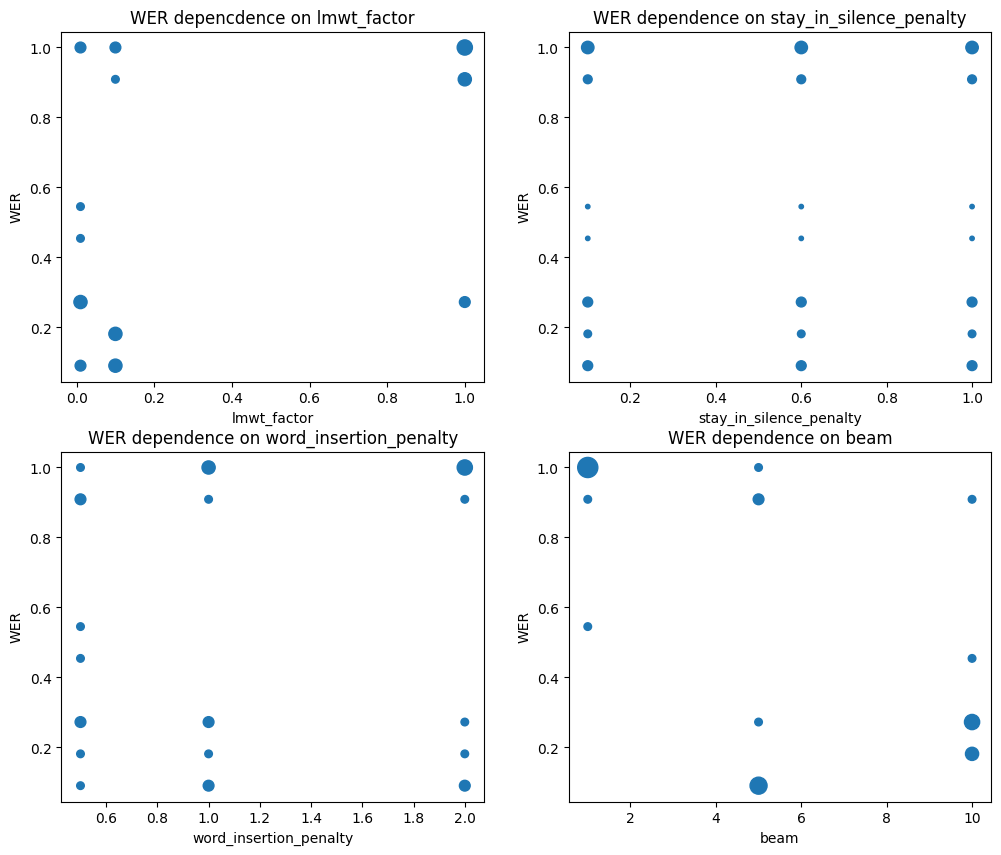

In [61]:
# зависимость WER от значений параметров
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

df = pd.read_csv('asr_results_for_grid.csv')
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(c1['lmwt_factor'], c1['WER'], s=c1['time']*10)
plt.title('WER depencdence on lmwt_factor')
plt.xlabel('lmwt_factor')
plt.ylabel('WER')

plt.subplot(2, 2, 2)
plt.scatter(c2['stay_in_silence_penalty'], c2['WER'], s=c2['time']*10)
plt.title('WER dependence on stay_in_silence_penalty')
plt.xlabel('stay_in_silence_penalty')
plt.ylabel('WER')

plt.subplot(2, 2, 3)
plt.scatter(c3['word_insertion_penalty'], c3['WER'], s=c3['time']*10)
plt.title('WER dependence on word_insertion_penalty')
plt.xlabel('word_insertion_penalty')
plt.ylabel('WER')

plt.subplot(2, 2, 4)
plt.scatter(c4['beam'], c4['WER'], s=c4['time']*10)
plt.title('WER dependence on beam')
plt.xlabel('beam')
plt.ylabel('WER')

plt.show()

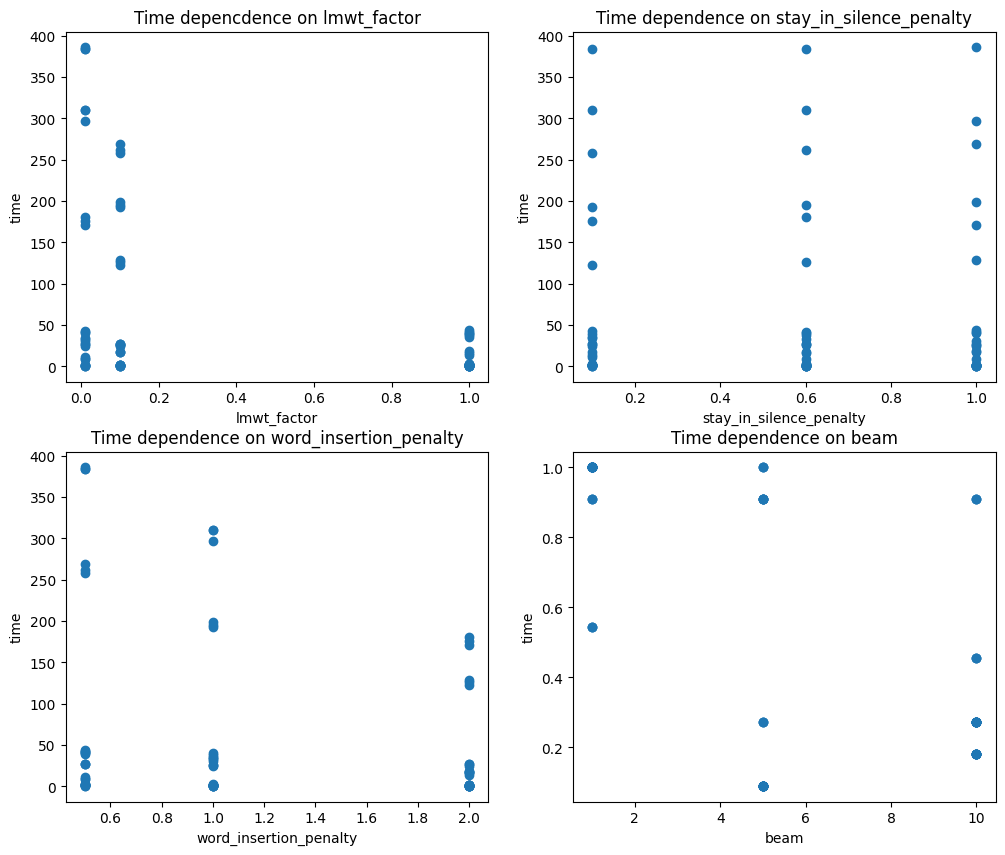

In [66]:
# зависимость time от значений параметров
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

df = pd.read_csv('asr_results_for_grid.csv')
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(df['lmwt_factor'], df['time'])
plt.title('Time depencdence on lmwt_factor')
plt.xlabel('lmwt_factor')
plt.ylabel('time')

plt.subplot(2, 2, 2)
plt.scatter(df['stay_in_silence_penalty'], df['time'])
plt.title('Time dependence on stay_in_silence_penalty')
plt.xlabel('stay_in_silence_penalty')
plt.ylabel('time')

plt.subplot(2, 2, 3)
plt.scatter(df['word_insertion_penalty'], df['time'])
plt.title('Time dependence on word_insertion_penalty')
plt.xlabel('word_insertion_penalty')
plt.ylabel('time')

plt.subplot(2, 2, 4)
plt.scatter(df['beam'], df['WER'])
plt.title('Time dependence on beam')
plt.xlabel('beam')
plt.ylabel('time')

plt.show()

In [71]:
# Лучшие значения параметров 
sorted_df = df.sort_values(by=['WER', 'time'])
params = sorted_df.iloc[1]
params

lmwt_factor                 0.100000
stay_in_silence_penalty     0.600000
word_insertion_penalty      2.000000
beam                        5.000000
WER                         0.090909
time                       17.144319
Name: 43, dtype: float64

# Дополнительное задание (2 балла)
Декодируйте всю коллекцию am_nlogprobs с подобраными ранее параметрами и посчитайте WER на этой выборке


In [102]:
# Заранее подготовленные negative log probability от модели из работы №3
with ReadHelper('ark:resources/lab4/test_am_nlogprobs.ark') as am_nlogprob_reader:
    am_nlogprobs = {uri: am_logprob  for uri, am_logprob in am_nlogprob_reader}

# задаем гиперпараметры
lmwt_factor = params['lmwt_factor']
stay_in_silence_penalty = params['stay_in_silence_penalty']
word_insertion_penalty = params['word_insertion_penalty']
beam_size = params['beam']
  
# собираем систему распознавания
t_fst = create_t_wfst()
l_fst = create_Lwfst_from_file(stay_in_silence_penalty=stay_in_silence_penalty, word_insertion_penalty=word_insertion_penalty)
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=lmwt_factor)
graph=OnTheFlyCompose([t_fst, l_fst, lm])
model = BeamSearcher(AM_PHONES, graph, beam_size=beam_size)

res_df = pd.DataFrame(columns=['uri', 'ref', 'hyp', 'wer'])
for uri in tqdm(am_nlogprobs.keys()):
    with open(uri+'.TXT') as f:
        ref = ' '.join(f.read().replace('.', ' ').split()[2:])
    hyp = model.decode(am_nlogprobs[uri])
    wer = jiwer.wer(ref, ' '.join(hyp.words))
    res_df.loc[len(res_df)] = [uri, ref, ' '.join(hyp.words), wer]
res_df.to_csv('asr_results_for_timit.csv', index=False)

Loading the LM will be faster if you build a binary file.
Reading /home/chernogor/workspace/nastya/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-593.6191963788784, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x762cc545c8f0>)). Mean score -593.62. Max -593.62: 100%|██████████| 198/198 [00:19<00:00, 10.10it/s]
  2%|▎         | 1/40 [00:19<12:44, 19.61s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=-329.94546579679064, time=180, words=['own', 'ask', 'meeting', 'care', 'reinforce', 'guy', 'cat'], state=(0, 0, <kenlm.State object at 0x762ca4e204f0>)). Mean score -329.33. Max -328.72: 100%|██████████| 181/181 [00:13<00:00, 13.04it/s]
  5%|▌         | 2/40 [00:33<10:17, 16.25s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=-705.7206153802963, time=247, words=['his', 'calf', 'tin', 'was', 'thin', 'none', 'haggard', 'end', 'is', 'beautiful', 'boots', 'warningly', 'chastity'], state=(0, 0, <kenlm.State object at 0x762ca59317f0>)). Mean score -705.72. Max -705.72: 100%|██████████| 248/248 [00:21<00:00, 11.29it/s]
  8%|▊         | 3/40 [00:55<11:37, 18.86s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-622.2035357138501, time=174, words=['the', 'reasons', 'fullness', 'tie', "i've", 'seemed', 'foolish', 'now'], state=(0, 0, <kenlm.State object at 0x762cc4ed9fb0>)). Mean score -622.20. Max -622.20: 100%|██████████| 175/175 [00:19<00:00,  9.15it/s]
 10%|█         | 4/40 [01:14<11:22, 18.97s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-580.3066236351415, time=186, words=['production', 'may', 'fall', 'far', 'below', 'expectations'], state=(0, 0, <kenlm.State object at 0x762c97f03cb0>)). Mean score -580.31. Max -580.31: 100%|██████████| 187/187 [00:11<00:00, 15.88it/s]
 12%|█▎        | 5/40 [01:26<09:33, 16.38s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-471.3329617360277, time=164, words=['pizzerias', 'are', 'convenient', 'fur', 'a', 'quick', 'lunch'], state=(0, 0, <kenlm.State object at 0x762ca23c2bb0>)). Mean score -471.33. Max -471.33: 100%|██████████| 165/165 [00:16<00:00, 10.07it/s]
 15%|█▌        | 6/40 [01:42<09:16, 16.38s/it]

Found 1 hypotheses


3 hyps. Best Hypothesis(score=-196.580702650814, time=153, words=['put', 'the', 'butcher', 'bought', 'table', 'a'], state=(0, 20851, <kenlm.State object at 0x762ca50e8970>)). Mean score -193.88. Max -191.61: 100%|██████████| 154/154 [00:14<00:00, 10.77it/s]  
 18%|█▊        | 7/40 [01:57<08:38, 15.70s/it]

Found 3 hypotheses


1 hyps. Best Hypothesis(score=-566.6963543078914, time=175, words=['drop', 'five', 'forms', 'in', 'the', 'box', 'before', 'you', 'go', 'out'], state=(0, 0, <kenlm.State object at 0x762ca50fcaf0>)). Mean score -566.70. Max -566.70: 100%|██████████| 176/176 [00:20<00:00,  8.60it/s]
 20%|██        | 8/40 [02:17<09:10, 17.22s/it]

Found 1 hypotheses


14 hyps. Best Hypothesis(score=-283.18801920589317, time=166, words=['her', 'wardrobe', 'concessionaire', 'only', 'skirts', 'unbound'], state=(0, 31623, <kenlm.State object at 0x762cac2f96f0>)). Mean score -280.21. Max -278.19: 100%|██████████| 167/167 [00:29<00:00,  5.67it/s]
 22%|██▎       | 9/40 [02:47<10:52, 21.05s/it]

Found 14 hypotheses


515 hyps. Best Hypothesis(score=-120.87472684011912, time=121, words=['elderly', 'people', 'are', 'often', 'negotiations'], state=(0, 7948, <kenlm.State object at 0x762ca50bda70>)). Mean score -119.43. Max -116.13: 100%|██████████| 122/122 [00:15<00:00,  7.68it/s]
 25%|██▌       | 10/40 [03:02<09:43, 19.46s/it]

Found 515 hypotheses


1 hyps. Best Hypothesis(score=-763.4040708623778, time=262, words=['she', 'head', 'your', 'arc', 'suit', 'in', 'greasy', 'wash', 'ward', 'a', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x762ca50a0ef0>)). Mean score -763.40. Max -763.40: 100%|██████████| 263/263 [00:30<00:00,  8.64it/s]
 28%|██▊       | 11/40 [03:33<11:01, 22.83s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=-615.8481934231547, time=206, words=["don't", 'ask', 'meeting', 'carry', 'enjoy', 'oily', 'rag', 'lie', 'that'], state=(0, 0, <kenlm.State object at 0x762cbb893370>)). Mean score -615.79. Max -615.73: 100%|██████████| 207/207 [00:21<00:00,  9.74it/s]
 30%|███       | 12/40 [03:54<10:25, 22.35s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=-672.9435806168367, time=219, words=['husky', 'young', 'men', 'he', 'said', 'with', 'thaw', 'distaste'], state=(0, 0, <kenlm.State object at 0x762cc492c3b0>)). Mean score -672.94. Max -672.94: 100%|██████████| 220/220 [00:19<00:00, 11.30it/s]
 32%|███▎      | 13/40 [04:14<09:39, 21.48s/it]

Found 1 hypotheses


267 hyps. Best Hypothesis(score=-488.1748300089738, time=228, words=['hum', 'how', 'unhurried', "they've", 'lush', 'divorce', 'see', 'hen', 'last'], state=(0, 0, <kenlm.State object at 0x762cc5233db0>)). Mean score -484.27. Max -484.25: 100%|██████████| 229/229 [00:31<00:00,  7.26it/s]
 35%|███▌      | 14/40 [04:45<10:37, 24.52s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=-810.5337472804041, time=370, words=['fuss', 'therapy', 'bullet', 'fish', 'a', 'news', 'see', 'is', 'achieved', 'gathering', 'expense', 'of', 'actual', "experiment's"], state=(0, 0, <kenlm.State object at 0x762cac397e70>)). Mean score -810.53. Max -810.53: 100%|██████████| 371/371 [00:47<00:00,  7.85it/s]
 38%|███▊      | 15/40 [05:32<13:04, 31.38s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=-408.07664941567197, time=135, words=['objects', 'made', 'of', 'pewter', 'of', 'bugle', 'a', 'fall'], state=(0, 0, <kenlm.State object at 0x762cac40efb0>)). Mean score -408.08. Max -408.08: 100%|██████████| 136/136 [00:13<00:00,  9.84it/s]
 40%|████      | 16/40 [05:46<10:26, 26.10s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=-667.096627077637, time=220, words=['the', 'morning', 'blew', 'a', 'gun', 'this', 'piled', 'a', 'web', 'glistening', 'knowed', 'in', 'the', 'sun'], state=(0, 0, <kenlm.State object at 0x762ca5c569b0>)). Mean score -667.07. Max -667.04: 100%|██████████| 221/221 [00:53<00:00,  4.16it/s]
 42%|████▎     | 17/40 [06:39<13:07, 34.24s/it]

Found 2 hypotheses


4 hyps. Best Hypothesis(score=-687.3691111899539, time=209, words=['cheap', 'stockings', 'run', 'the', 'first', 'time', 'them', 'on', 'do'], state=(0, 0, <kenlm.State object at 0x762ca5cba430>)). Mean score -686.94. Max -686.38: 100%|██████████| 210/210 [00:28<00:00,  7.30it/s]
 45%|████▌     | 18/40 [07:08<11:57, 32.59s/it]

Found 4 hypotheses


1 hyps. Best Hypothesis(score=-643.7631175976733, time=200, words=["don't", 'do', 'chop', 'leisure', 'early', 'dish', 'is'], state=(0, 0, <kenlm.State object at 0x762ca5bc8db0>)). Mean score -643.76. Max -643.76: 100%|██████████| 201/201 [00:14<00:00, 14.08it/s]
 48%|████▊     | 19/40 [07:23<09:29, 27.10s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-595.0764187883722, time=191, words=['cow', 'see', 'a', 'makes', 'bones', 'entity', 'thought', 'wrong'], state=(0, 0, <kenlm.State object at 0x762ca5bb1670>)). Mean score -595.08. Max -595.08: 100%|██████████| 192/192 [00:34<00:00,  5.62it/s]
 50%|█████     | 20/40 [07:57<09:44, 29.22s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-517.3158141209051, time=188, words=['she', 'had', 'derived', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x762ca5b93c70>)). Mean score -517.32. Max -517.32: 100%|██████████| 189/189 [00:18<00:00, 10.29it/s]
 52%|█████▎    | 21/40 [08:15<08:13, 25.97s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-223.1908464203949, time=146, words=["don't", 'ask', 'meeting', 'kerosene', 'angular', 'cat'], state=(0, 0, <kenlm.State object at 0x762ca5b138b0>)). Mean score -223.19. Max -223.19: 100%|██████████| 147/147 [00:09<00:00, 15.99it/s]
 55%|█████▌    | 22/40 [08:24<06:16, 20.94s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-438.53423583199225, time=274, words=['in', 'wage', 'negotiations', 'these', 'knowed', 'establish', 'agony', 'zealous', 'unit', 'assistant'], state=(0, 0, <kenlm.State object at 0x762ca5b0c6b0>)). Mean score -438.53. Max -438.53: 100%|██████████| 275/275 [00:12<00:00, 22.42it/s]
 57%|█████▊    | 23/40 [08:37<05:11, 18.34s/it]

Found 1 hypotheses


267 hyps. Best Hypothesis(score=-520.1422152297441, time=168, words=['heave', 'on', 'those', 'ropes', 'the', "boat's", 'come', 'unstuck'], state=(0, 0, <kenlm.State object at 0x762ca4d31270>)). Mean score -515.96. Max -515.95: 100%|██████████| 169/169 [00:30<00:00,  5.57it/s]
 60%|██████    | 24/40 [09:07<05:51, 21.94s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-626.2266007109777, time=208, words=['materials', 'surrounded', 'my', 'lincoln', 'lay', 'red', 'wide', 'tore', 'buff'], state=(0, 0, <kenlm.State object at 0x762ca4c4e070>)). Mean score -626.23. Max -626.23: 100%|██████████| 209/209 [00:26<00:00,  7.91it/s]
 62%|██████▎   | 25/40 [09:33<05:49, 23.29s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-388.3327054736631, time=144, words=['artificial', 'intelligence', 'society', 'real'], state=(0, 0, <kenlm.State object at 0x762ca4ca0270>)). Mean score -388.33. Max -388.33: 100%|██████████| 145/145 [00:18<00:00,  7.72it/s] 
 65%|██████▌   | 26/40 [09:52<05:07, 21.94s/it]

Found 1 hypotheses


5 hyps. Best Hypothesis(score=-336.45772798580015, time=108, words=['a', 'small', 'boy', 'pulled', 'warm', 'on', 'hook', 'to'], state=(0, 0, <kenlm.State object at 0x762ca2812ef0>)). Mean score -335.94. Max -335.26: 100%|██████████| 109/109 [00:17<00:00,  6.29it/s]
 68%|██████▊   | 27/40 [10:09<04:27, 20.56s/it]

Found 5 hypotheses


2 hyps. Best Hypothesis(score=-430.1137200892192, time=123, words=['a', 'chosen', 'few', 'wool', 'be', 'come', 'generals'], state=(0, 0, <kenlm.State object at 0x762ca4cfe3f0>)). Mean score -430.08. Max -430.04: 100%|██████████| 124/124 [00:18<00:00,  6.57it/s]
 70%|███████   | 28/40 [10:28<04:00, 20.06s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=-493.0851240705969, time=174, words=['only', 'the', 'most', 'accomplish', 'are', 'this', 'obtain', 'pop', 'ya', 'leather', 'ease'], state=(0, 0, <kenlm.State object at 0x762ca28be170>)). Mean score -493.09. Max -493.09: 100%|██████████| 175/175 [00:30<00:00,  5.74it/s]
 72%|███████▎  | 29/40 [10:59<04:15, 23.19s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-351.51562213746826, time=189, words=['the', 'fish', 'began', 'topography', 'together', 'surface', 'of', 'the', 'small', 'wake'], state=(0, 0, <kenlm.State object at 0x762ca4c743b0>)). Mean score -351.52. Max -351.52: 100%|██████████| 190/190 [00:22<00:00,  8.56it/s]
 75%|███████▌  | 30/40 [11:21<03:49, 22.90s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-392.30608101347786, time=185, words=['she', 'head', 'your', 'dark', 'suit', 'together', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x762ca2842c30>)). Mean score -392.31. Max -392.31: 100%|██████████| 186/186 [00:17<00:00, 10.93it/s]
 78%|███████▊  | 31/40 [11:38<03:10, 21.14s/it]

Found 1 hypotheses


329 hyps. Best Hypothesis(score=-83.98691899967774, time=171, words=["don't", 'ask', 'meeting', 'kerosene', 'agricultural'], state=(0, 31869, <kenlm.State object at 0x762ca27b29b0>)). Mean score -83.30. Max -79.24: 100%|██████████| 172/172 [00:08<00:00, 20.22it/s]
 80%|████████  | 32/40 [11:47<02:18, 17.35s/it]

Found 329 hypotheses


1 hyps. Best Hypothesis(score=-474.11014985560564, time=171, words=['dances', 'alternated', 'with', 'thump', 'or', 'spoken', 'verses'], state=(0, 0, <kenlm.State object at 0x762ca2757cf0>)). Mean score -474.11. Max -474.11: 100%|██████████| 172/172 [00:27<00:00,  6.19it/s]
 82%|████████▎ | 33/40 [12:14<02:23, 20.49s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-440.5445512019705, time=145, words=['wife', 'author', 'ran', 'him', 'off', 'year', 'sixty', 'years', 'ago'], state=(0, 0, <kenlm.State object at 0x762ca26705b0>)). Mean score -440.54. Max -440.54: 100%|██████████| 146/146 [00:37<00:00,  3.89it/s] 
 85%|████████▌ | 34/40 [12:52<02:33, 25.61s/it]

Found 1 hypotheses


267 hyps. Best Hypothesis(score=-749.5718889509678, time=303, words=['here', 'he', 'is', 'quite', 'persuasively', 'even', 'verses', 'modified', 'mean', 'essential', 'slyness'], state=(0, 0, <kenlm.State object at 0x762ca27395f0>)). Mean score -744.75. Max -744.73: 100%|██████████| 304/304 [00:30<00:00,  9.97it/s]
 88%|████████▊ | 35/40 [13:23<02:15, 27.09s/it]

Found 1 hypotheses


28 hyps. Best Hypothesis(score=-428.9928779606144, time=144, words=['the', "cat's", 'meow', 'always', 'hurts', 'my', 'use'], state=(0, 0, <kenlm.State object at 0x762ca25a3130>)). Mean score -424.87. Max -424.59: 100%|██████████| 145/145 [00:33<00:00,  4.29it/s]
 90%|█████████ | 36/40 [13:56<01:56, 29.12s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=-478.9902217639668, time=194, words=['cliff', 'was', 'soothed', 'by', 'the', 'look', 'sherbet', 'snips', "i've", 'job'], state=(0, 0, <kenlm.State object at 0x762ca250cb30>)). Mean score -478.99. Max -478.99: 100%|██████████| 195/195 [00:27<00:00,  7.12it/s]
 92%|█████████▎| 37/40 [14:24<01:25, 28.61s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-675.8804401977246, time=288, words=['each', 'untimely', 'think', 'come', 'wash', 'psychopath', 'sighing', 'with', 'thimble', 'age', 'cow', 'nevada', 'heating', 'zig-zagged', "'em", 'part'], state=(0, 0, <kenlm.State object at 0x762ca24de370>)). Mean score -675.88. Max -675.88: 100%|██████████| 289/289 [00:36<00:00,  7.83it/s]
 95%|█████████▌| 38/40 [15:01<01:02, 31.11s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-496.1795561469332, time=149, words=['chain', 'may', 'earn', 'more', 'money', 'by', 'working', 'the', 'hard'], state=(0, 0, <kenlm.State object at 0x762c97cd8ab0>)). Mean score -496.18. Max -496.18: 100%|██████████| 150/150 [00:21<00:00,  7.08it/s]
 98%|█████████▊| 39/40 [15:22<00:28, 28.13s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=-474.80012677082044, time=159, words=['youngsters', 'love', 'common', 'candy', 'eggs', 'treats'], state=(0, 0, <kenlm.State object at 0x762ca2654cb0>)). Mean score -474.80. Max -474.80: 100%|██████████| 160/160 [00:21<00:00,  7.51it/s]
100%|██████████| 40/40 [15:43<00:00, 23.59s/it]

Found 1 hypotheses


In [103]:
res_df

,uri,ref,hyp,wer
0,timit/data/TEST/DR1/FAKS0/SA1,She had your dark suit in greasy wash water al...,she had your dark suit in greasy wash water al...,0.090909
1,timit/data/TEST/DR1/FAKS0/SA2,Don't ask me to carry an oily rag like that,own ask meeting care reinforce guy cat,0.900000
2,timit/data/TEST/DR1/FAKS0/SI1573,His captain was thin and haggard and his beaut...,his calf tin was thin none haggard end is beau...,0.714286
3,timit/data/TEST/DR1/FAKS0/SI2203,The reasons for this dive seemed foolish now,the reasons fullness tie i've seemed foolish now,0.500000
4,timit/data/TEST/DR1/FAKS0/SI943,Production may fall far below expectations,production may fall far below expectations,0.166667
5,timit/data/TEST/DR1/FAKS0/SX133,Pizzerias are convenient for a quick lunch,pizzerias are convenient fur a quick lunch,0.285714
6,timit/data/TEST/DR1/FAKS0/SX223,Put the butcher block table in the garage,put the butcher bought table a,0.625000
7,timit/data/TEST/DR1/FAKS0/SX313,Drop five forms in the box before you go out,drop five forms in the box before you go out,0.100000
8,timit/data/TEST/DR1/FAKS0/SX403,Her wardrobe consists of only skirts and blouses,her wardrobe concessionaire only skirts unbound,0.625000
9,timit/data/TEST/DR1/FAKS0/SX43,Elderly people are often excluded,elderly people are often negotiations,0.400000
